In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq


from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [2]:
import os
import os.path as osp
import copy
import torch
import hydra
import logging
import scipy.ndimage
import numpy as np
from PIL import Image
import open3d as o3d

# Import building function for model and dataset
from torch_points3d.datasets.dataset_factory import instantiate_dataset
from torch_points3d.models.model_factory import instantiate_model

# Import BaseModel / BaseDataset for type checking
from torch_points3d.models.base_model import BaseModel
from torch_points3d.datasets.base_dataset import BaseDataset

# Import from metrics
from torch_points3d.metrics.base_tracker import BaseTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
from torch_points3d.metrics.model_checkpoint import ModelCheckpoint

# Utils import
from torch_points3d.utils.colors import COLORS
from torch_points3d.utils.wandb_utils import Wandb
from torch_points3d.utils.config import getattr_recursive
from torch_points3d.visualization import Visualizer
from torch_points3d.core.data_transform.transforms import PointcloudMerge
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS


log = logging.getLogger(__name__)

def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds




Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/end-to-end.yaml'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small_6views'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 7.7 sec.


In [4]:
# from torch_points3d.models.model_factory import instantiate_model

# # ViT_masks 3rd run
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run' # 3rd run

# # # ViT_masks 9 views
# # checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-01-25/16-02-53'


# # # MVFusion_orig
# # checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/MVFusion_orig'


# # # M2F masks 6 views small
# # checkpoint_dir = "/home/fsun/DeepViewAgg/outputs/MVFusion_3D_6_views_m2f_masks"

# # Create the model
# print(f"Creating model: {cfg.model_name}")
# model = instantiate_model(cfg, dataset)
# # print(model)

# # Load the checkpoint and recover the 'best_miou' model weights
# checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# # Prepare the model for training
# model = model.cuda()
# print('Model loaded')


In [5]:
# import pandas as pd
# pd.set_option('display.max_rows', 50)

# # Create validation loader
# dataset.create_dataloaders(
#     model,
#     1,
#     False,
#     17,
#     False,
#     train_only=False,
#     val_only=True,
#     test_batch_size=1
# )

# mapping_idx_to_scan_names = getattr(dataset.val_dataset, "MAPPING_IDX_TO_SCAN_{}_NAMES".format(dataset.val_dataset.split.upper()))
# # print(mapping_idx_to_scan_names)
# # scan_name = mapping_idx_to_scan_names[0]
# # scan_name

# Model playground

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModelA(nn.Module):
    def __init__(self):
        super(MyModelA, self).__init__()
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    

class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.fc1 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        return x


class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(4, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

# Create models and load state_dicts    
modelA = MyModelA()
modelB = MyModelB()
# Load state dicts
# modelA.load_state_dict(torch.load(PATH))
# modelB.load_state_dict(torch.load(PATH))

model = MyEnsemble(modelA, modelB)
x1, x2 = torch.randn(1, 10), torch.randn(1, 20)
output = model(x1, x2)
output

tensor([[ 0.7763, -0.2771]], grad_fn=<AddmmBackward0>)

In [345]:
import time
import PIL.Image
import torchvision.transforms as transforms

preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
    
def load_sample():
    im = Image.open("/scratch-shared/fsun/data/scannet/scans/scene0011_00/color_resized/0.png")
    im = preprocessing(im).unsqueeze(0)
        
    label = Image.open("/scratch-shared/fsun/data/scannet/scans/scene0011_00/label-filt-scannet20/0.png")
    label = torch.tensor(np.asarray(label)).long() - 1   # -1 becomes ignore label
    label = label.unsqueeze(0)
    
    return im, label, None

def train(model, loss_fn, optimizer, load_sample_fn=None, epochs=1, verbose=False):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)

        x, y, image_data = load_sample_fn

        running_loss = 0.0

  
        # zero the gradients
        optimizer.zero_grad()
        
        if image_data is not None:
            outputs = model(x.cuda(), image_data.to('cuda:0'))
        else:
            outputs = model(x.cuda(), None)
                
        loss = loss_fn(outputs, y.cuda())
        
        train_loss.append(loss.item())

        # the backward pass frees the graph memory, so there is no 
        # need for torch.no_grad in this training pass
        loss.backward()
        optimizer.step()
        # scheduler.step()



        # clear_output(wait=True)
        if verbose:
            print('Loss: {}  AllocMem (Mb): {}'.format(loss, torch.cuda.memory_allocated()/1024/1024))
        # print(torch.cuda.memory_summary())


    time_elapsed = time.time() - start
    print("final loss: ", train_loss[-1])
    return train_loss

In [101]:
unet = UNET(3, 20)
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optim = torch.optim.Adam(unet.parameters(), lr=0.01)
loss = train(unet, loss_fn, optim, load_sample, epochs=100)

Epoch 0/99
----------
Loss: 2.985055446624756  AllocMem (Mb): 43.68994140625
Epoch 1/99
----------
Loss: 2.732470989227295  AllocMem (Mb): 44.25244140625
Epoch 2/99
----------
Loss: 2.4248251914978027  AllocMem (Mb): 43.68994140625
Epoch 3/99
----------
Loss: 2.1522183418273926  AllocMem (Mb): 44.25244140625
Epoch 4/99
----------
Loss: 1.9302713871002197  AllocMem (Mb): 43.68994140625
Epoch 5/99
----------
Loss: 1.7416588068008423  AllocMem (Mb): 44.25244140625
Epoch 6/99
----------
Loss: 1.5968677997589111  AllocMem (Mb): 43.68994140625
Epoch 7/99
----------
Loss: 1.4866712093353271  AllocMem (Mb): 44.25244140625
Epoch 8/99
----------
Loss: 1.4251577854156494  AllocMem (Mb): 43.68994140625
Epoch 9/99
----------
Loss: 1.3266100883483887  AllocMem (Mb): 44.25244140625
Epoch 10/99
----------
Loss: 1.2584136724472046  AllocMem (Mb): 43.68994140625
Epoch 11/99
----------
Loss: 1.1968885660171509  AllocMem (Mb): 44.25244140625
Epoch 12/99
----------
Loss: 1.1327550411224365  AllocMem (Mb): 

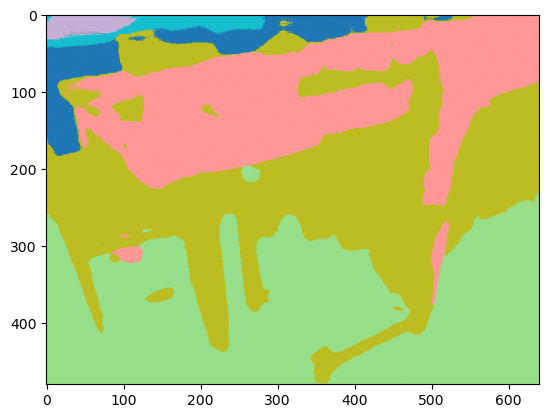

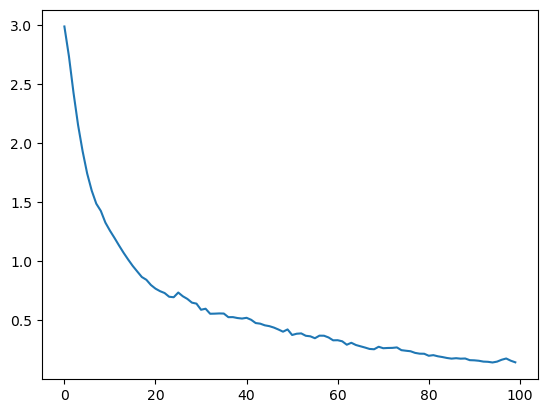

In [102]:
x, y = load_sample()

unet.eval()
with torch.no_grad():
    out_scores = unet(x.cuda())

pred = out_scores.squeeze(0)   # squeeze when bs=1
pred = F.softmax(pred, 0)
pred = pred.argmax(0).cpu()

rgb_pred = np.array(CLASS_COLORS)[pred]

plt.imshow(rgb_pred / 255)
plt.show()

plt.plot(loss)

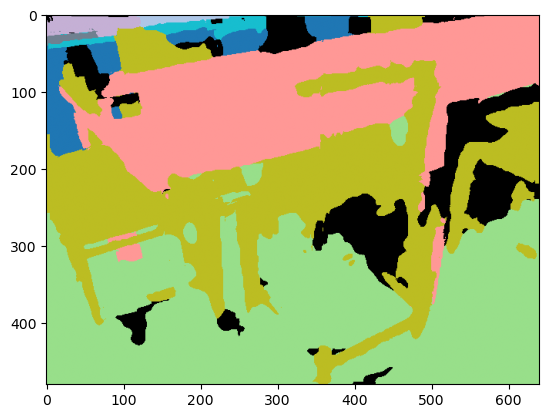

In [9]:
gt_rgb = np.array(CLASS_COLORS)[y[0]] / 255
plt.imshow(gt_rgb)

In [11]:
# plt.plot(loss1, label='0.005')
# plt.plot(loss2, label='0.01')
# plt.legend()
# plt.show()

In [30]:
mm_data = dataset.val_dataset[200]

In [31]:
mm_data

MMData(
    data = Data(coords=[47599, 3], grid_size=[1], id_scan=[1], mapping_index=[47599], mvfusion_input=[38546, 6, 10], origin_id=[47599], pos=[47599, 3], rgb=[47599, 3], x=[47599, 3], y=[47599])
    image = ImageData(num_settings=1, num_views=100, num_points=47599, device=cpu)
)

In [32]:
images = mm_data.modalities['image'][0].x

image_paths = mm_data.modalities['image'][0].path

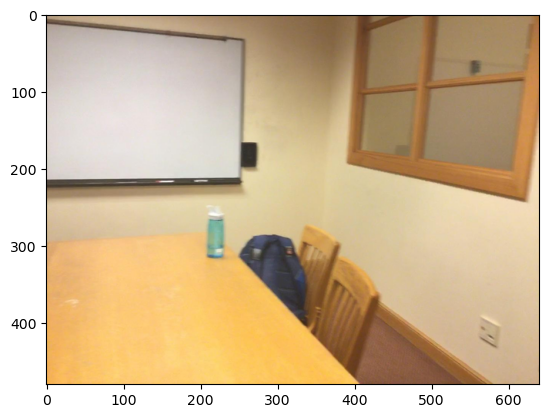

In [38]:
for i in range(1):
    p = image_paths[i]
    p = p.replace("/project", "/scratch-shared").replace("/sens/color", "/color_resized").replace('.jpg', '.png')
    im = Image.open(p)
    plt.imshow(im)

In [325]:
visualize_mm_data(get_seen_points(mm_data), figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [315]:
# point1 = 0.54, 1.63, 0.58
# point2 = 1.51, 0.99, -0.6

# between1 = mm_data.x < torch.tensor([1.51, 1.63, 0.58])
# between2 = mm_data.x > torch.tensor([0.54, 0.99, -0.6])

# keep_mask = torch.all(torch.cat((between1, between2), -1), -1)

# subset_data = mm_data[keep_mask]
# visualize_mm_data(subset_data, figsize=1000, pointsize=3, voxel=0.02, show_2d=True, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

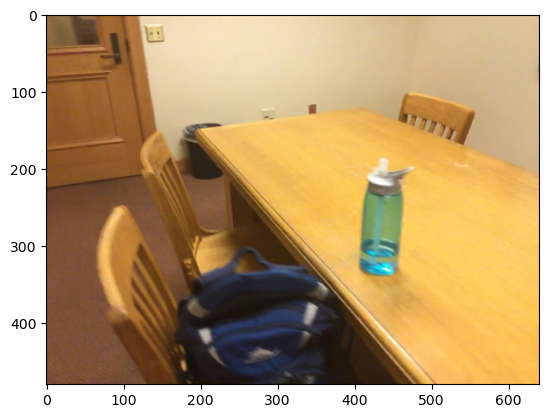

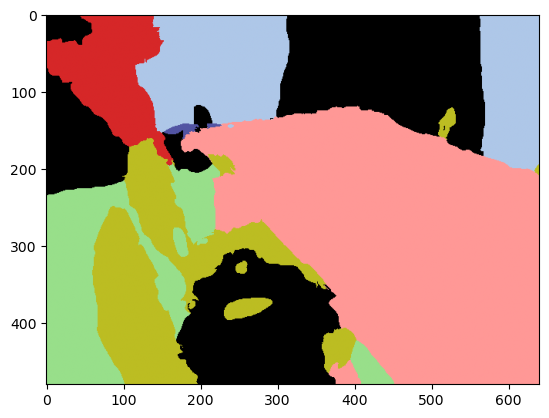

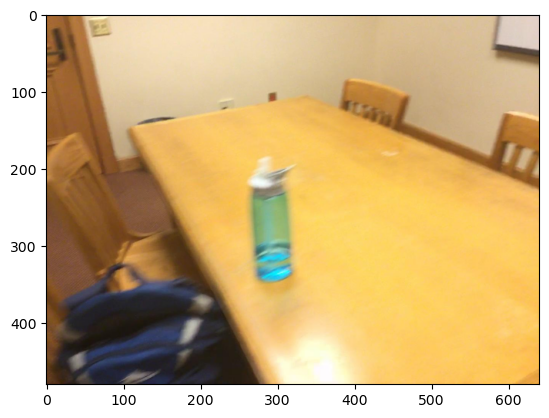

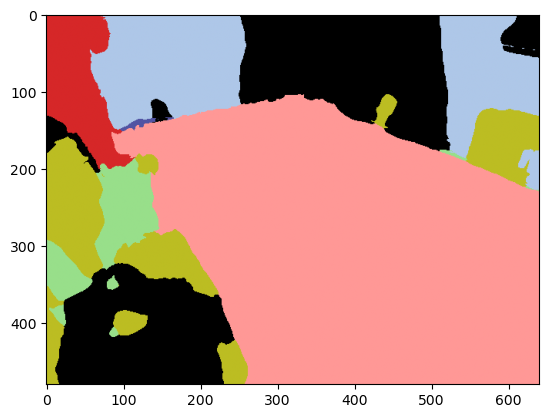

In [326]:
# views = [subset_data.modalities['image'][0][4], subset_data.modalities['image'][0][22]]

view_idx = [38, 64]

mm_data = 

for idx in view_idx:
    v = mm_data.modalities['image'][0][idx]
    p = v.path[0]
    p = p.replace("/project", "/scratch-shared").replace("/sens/color", "/color_resized").replace('.jpg', '.png')
    im = Image.open(p)
    plt.imshow(im)
    plt.show()
    
    
    label = Image.open(v.gt_mask_path[0])
    label = torch.tensor(np.asarray(label)).long() - 1   # -1 becomes ignore label
    label = label.unsqueeze(0)    
    gt_rgb = np.array(CLASS_COLORS)[label[0]] / 255
    plt.imshow(gt_rgb)
    plt.show()
    
# im1 = subset_data.modalities['image'][0][4].x
# gt1 = subset_data.modalities['image'][0][4].gt_mask

# im2 = subset_data.modalities['image'][0][22].x
# gt2 = subset_data.modalities['image'][0][22].gt_mask

In [328]:
from torch import nn
import torch.nn.functional as F

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
        
    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

    def forward(self, x, image_data):
        
        if image_data is not None:
        
            # maxpool common features in views
            feature_map = image_data.get_mapped_features()
            csr_idx = image_data.view_csr_indexing

            pooled_features = segment_gather_csr(feature_map, csr_idx, reduce='max')

            x[image_data.feature_map_indexing] = pooled_features
        
        # downsampling part
        conv1 = self.conv1(x)
#         print(f'{x.shape} conv1 ', conv1.shape)
        conv2 = self.conv2(conv1)
#         print(f'{conv1.shape} conv2 ', conv2.shape)
        conv3 = self.conv3(conv2)
#         print(f'{conv2.shape} conv3 ', conv3.shape)

        upconv3 = self.upconv3(conv3)
#         print(f'{conv3.shape} upconv3 ', upconv3.shape)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
#         print(f'{torch.cat([upconv3, conv2], 1).shape} upconv2 ', upconv2.shape)

        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
#         print(f'{torch.cat([upconv2, conv1], 1).shape} upconv1 ', upconv1.shape)

        return upconv1



In [329]:
from torch_points3d.modules.multimodal.pooling import segment_gather_csr

feature_map = mm_data.modalities['image'][0][view_idx].get_mapped_features()
csr_idx = mm_data.modalities['image'][0][view_idx].view_csr_indexing


print("feature map: ", feature_map)
pooled_features = segment_gather_csr(feature_map, csr_idx, reduce='max')

y = mm_data.modalities['image'][0][view_idx].x.clone()
print(y.shape)

# feature_map.shape, pooled_features.shape

batch_idx, _, h, w = mm_data.modalities['image'][0][view_idx].feature_map_indexing

y[batch_idx, :, h, w] = pooled_features


torch.equal(mm_data.modalities['image'][0][view_idx].x, y)

feature map:  tensor([[ 0.0741, -0.6001, -1.0898],
        [-0.2856, -0.7752, -1.1421],
        [-0.3369, -0.8627, -1.0550],
        ...,
        [ 0.6906, -0.2150, -0.8981],
        [ 0.7248, -0.2325, -0.8807],
        [ 0.2111, -0.4951, -1.1073]])
torch.Size([2, 3, 240, 320])


False

In [330]:
(csr_idx[1:] - csr_idx[:-1]).unique(return_counts=True)

(tensor([0, 1, 2]), tensor([43855,  1850,  1894]))

In [334]:
def load_sample_multiview(return_image_data=False):
#     view_idx = [5, 22]
    views = mm_data.modalities['image'][0][view_idx]
        
    if return_image_data:
        return views.x, views.gt_mask.squeeze(1), views
    
    
    
    
    
    return views.x, views.gt_mask.squeeze(1), None


def show_sample(use_image_data=False):
    x, y, image_data = load_sample_multiview(use_image_data)

    unet.eval()
    with torch.no_grad():
        if image_data is not None:
            out_scores = unet(x.cuda(), image_data=image_data.to('cuda:0'))
        else:
            out_scores = unet(x.cuda(), image_data=None)

    for i in range(len(view_idx)):
        pred = out_scores[i]  # squeeze when bs=1
        pred = F.softmax(pred, 0)
        pred = pred.argmax(0).cpu()

        rgb_pred = np.array(CLASS_COLORS)[pred]

        plt.imshow(rgb_pred / 255)
        plt.show()

In [348]:
N_EPOCHS = 300

final loss:  0.06608247756958008


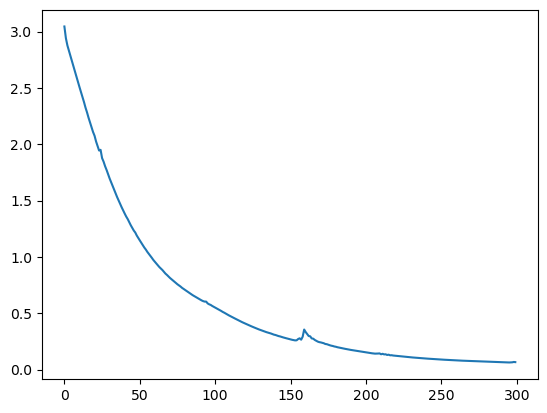

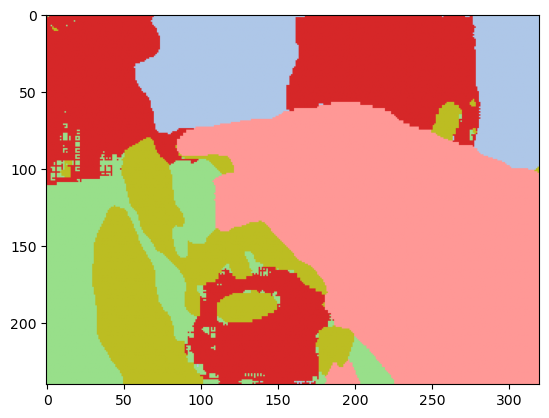

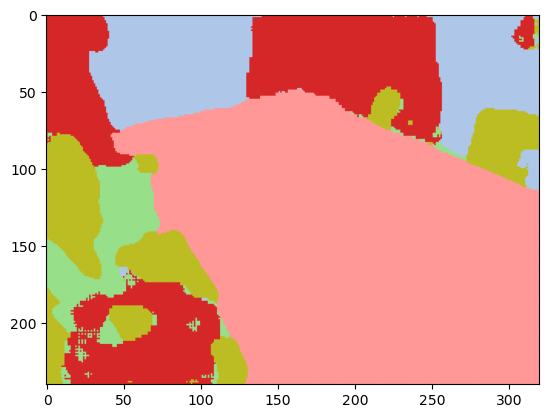

In [351]:
# With feature sharing
unet = UNET(3, 20).cuda()
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optim = torch.optim.Adam(unet.parameters(), lr=0.001)
loss = train(unet, loss_fn, optim, load_sample_multiview(False), epochs=N_EPOCHS)

plt.plot(loss)
plt.show()

show_sample(use_image_data=True)

final loss:  0.05336489528417587


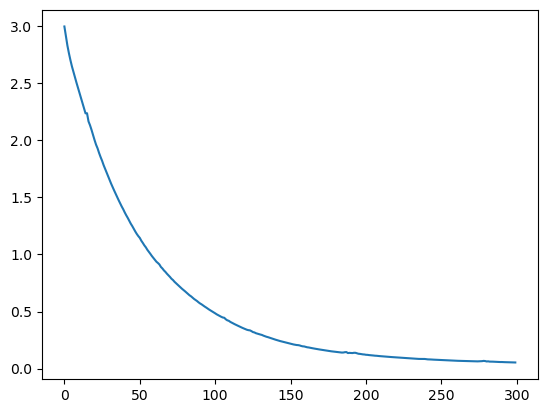

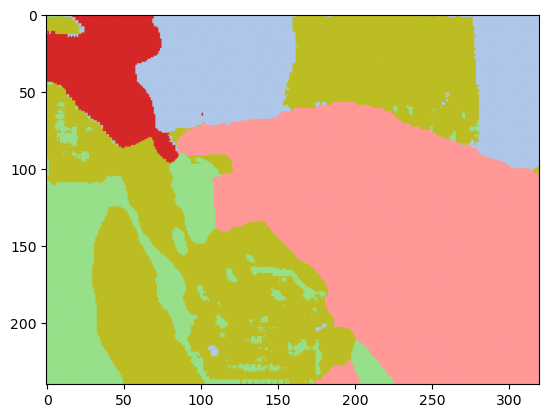

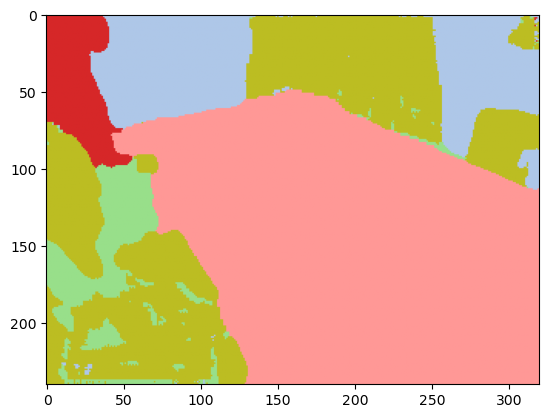

In [352]:
# Baseline UNet
unet = UNET(3, 20).cuda()
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optim = torch.optim.Adam(unet.parameters(), lr=0.001)
loss = train(unet, loss_fn, optim, load_sample_multiview(False), epochs=N_EPOCHS)

plt.plot(loss)
plt.show()

show_sample(use_image_data=False)

